# Problem Description

- Cancer accounted for nearly 10 million deaths in 2020. Or, put another way, 1 in every 6 deaths was caused by cancer (WHO, 2022).
- Even though we don't have a cure for cancer, early detection of it will go a long way in preventing many deaths (WHO, 2022).
- The dataset for this challenge is sourced from a modified version of PCam benchmark dataset (Kaggle, 2018). 
- The original dataset contains hundreds of thousands of images of pathology scans that have been labelled as cancerous or non-cancerous. 
- The Kaggle dataset removed duplicates from the original dataset to make it easier for people to train ML models. 
- **Problem**: Create a deep learning model to identify metastatic cancer in pathology scans.

**Data Description**

- The dataset consists of images in 2 folders: `training` & `test`
    - Training set contains 220,025 images
    - Test set contains 57,458 images
- Each image is 96 by 96 pixes
- Each image contains 3 color channels: Red, Green & Blue
- Authors have tried to put the _cancerous tissue_ in the center of each image. But it wasn't possible to do for every image.

**References**

- Ehteshami Bejnordi, et al. (2017). Diagnostic assessment of deep learning algorithms for detection of lymph node metastases in women with breast cancer. JAMA, 318(22), 2199. https://doi.org/10.1001/jama.2017.14585 
- Histopathologic Cancer detection. Kaggle. (2018). Retrieved October 10, 2022, from https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview 
- Veeling, B. S., Linmans, J., Winkens, J., Cohen, T., &amp; Welling, M. (2018). Rotation equivariant CNNS for digital pathology. Medical Image Computing and Computer Assisted Intervention – MICCAI 2018, 210–218. https://doi.org/10.1007/978-3-030-00934-2_24 
- WHO. (2022, February 3). Cancer. World Health Organization. Retrieved October 10, 2022, from https://www.who.int/news-room/fact-sheets/detail/cancer 

# Exploratory Data Analysis

The data has already been split into training & test sets by the competition organizers. 

In [322]:
import numpy as np 
import pandas as pd 
import os
import random

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Input
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

In [323]:
tf.__version__

'2.10.0'

In [324]:
test_path = './histopathologic-cancer-detection/test/'
train_path = './histopathologic-cancer-detection/train/'
train_data = pd.read_csv('./histopathologic-cancer-detection/train_labels.csv')

In [325]:
train_data.shape

(220025, 2)

In [326]:
train_data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


`train_data` contains the filenames in the `id` column and the correct label for them. The `label` is marked 1 if tumor tissue was found, 0 otherwise.

In [327]:
print(f'training: {len(os.listdir(train_path))}')
print(f'test: {len(os.listdir(test_path))}')

training: 220025
test: 57458


* There are 220025 images in the `training` dataset and 57458 images in the `test` dataset.

In [328]:
train_data['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

<AxesSubplot: ylabel='label'>

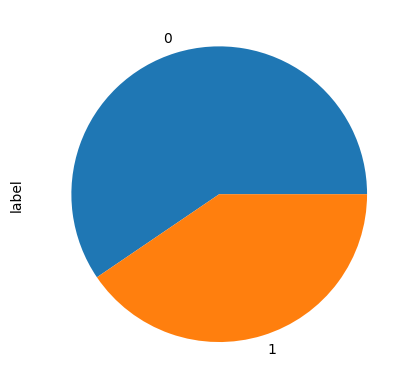

In [329]:
train_data['label'].value_counts().plot(kind='pie')

* The class distribution in the training dataset is _slightly_ uneven. 
* For now, I'll be skipping the steps to rebalance the dataset. But based on the results of the CNN, I might re-visit this decision.

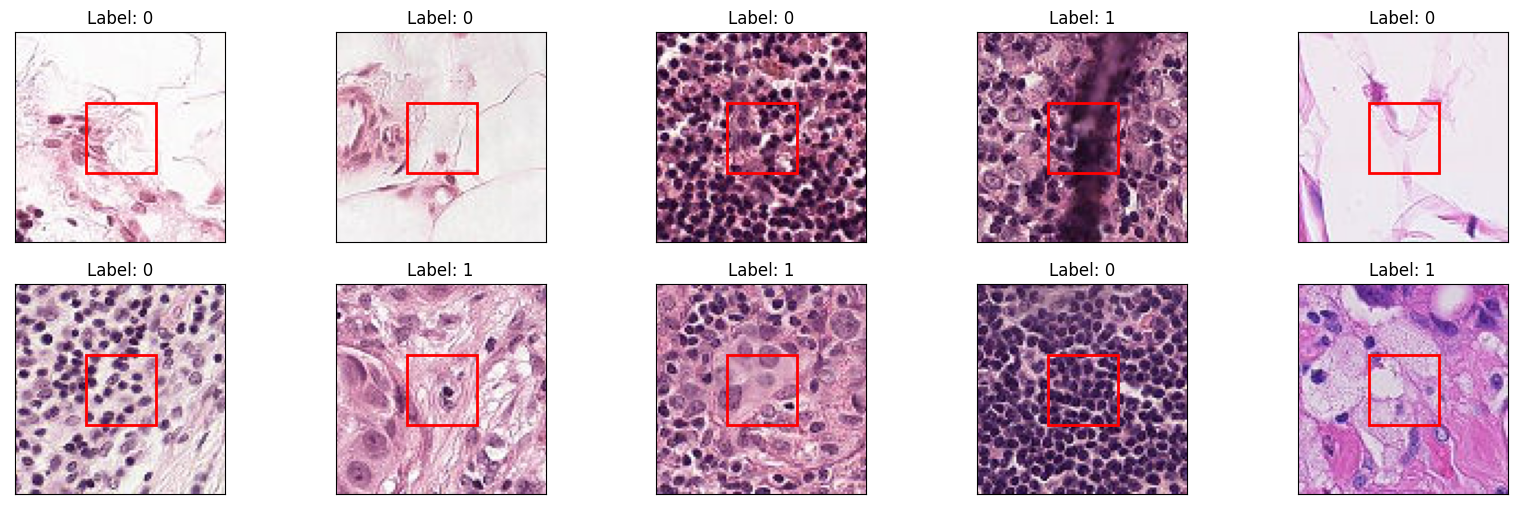

In [203]:
fig = plt.figure(figsize=(20, 6))

for idx, img in enumerate(np.random.choice(os.listdir(train_path), 10)):
    ax = fig.add_subplot(2, 10//2, idx+1, xticks=[], yticks=[])
    im = Image.open(f"{train_path}" + img)
    plt.imshow(im)
    lab = train_data.loc[train_data['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {lab}')
    box = patches.Rectangle((32,32),32,32, linewidth=2, edgecolor='r',facecolor='none', linestyle='-')
    ax.add_patch(box)

* With a quick visual analysis, I can't distinctly differentiate the scans that have a tumor (label = 1) from those that don't. But then again, I am not a radiologist :) 
* It will be really interesting to see how a ML algorithm solves this challenge. 

# Model Architecture

## Create the training & validation sets

In [330]:
train_df, valid_df = train_test_split(train_data, test_size=0.25, random_state=42, stratify=train_data.label)

train_df.shape, valid_df.shape

((165018, 2), (55007, 2))

In [331]:
train_df['id'] = train_df['id'] + '.tif'
valid_df['id'] = valid_df['id'] + '.tif'

In [332]:
# train_datagen below complains if the label values aren't string 
train_df['label'] = train_df['label'].astype(str)
valid_df['label'] = valid_df['label'].astype(str)

In [76]:
train_datagen=ImageDataGenerator(
    rescale=1/255
)

train_generator=train_datagen.flow_from_dataframe(dataframe=train_df,directory=train_path,
                x_col="id",y_col="label",batch_size=32,seed=42,shuffle=True,
                class_mode="binary",target_size=(96,96))

valid_generator=train_datagen.flow_from_dataframe(dataframe=valid_df,directory=train_path,
                x_col="id",y_col="label",batch_size=32,seed=42,shuffle=True,
                class_mode="binary",target_size=(96,96))

Found 165018 validated image filenames belonging to 2 classes.
Found 55007 validated image filenames belonging to 2 classes.


## Define helper functions

In [339]:
import itertools
def plot_confusion_matrix(cm, classes,title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[1]), range(cm.shape[0])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def evaluate_model(history, model, X_validation, y_validation):
    if history is not None:
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model One Accuracy per Epoch')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'validate'], loc='upper left')
        plt.show();

        # plot model loss per epoch
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model One Loss per Epoch')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validate'], loc='upper left')
        plt.show();
    
    # Show confusion matirx
    y_valid_pred = model.predict(X_validation)
    y_valid_pred = [0 if pred < 0.5 else 1 for pred in y_valid_pred]
    cm_train = np.flip(confusion_matrix(y_validation, y_valid_pred))
    plot_confusion_matrix(cm_train,["Non-cancerous tissue", "Cancerous tissue"])
    plt.show();
    
    # Calculate the fun metrics
    print(f'Total images with cancerous tissue detected in validation set: {cm_train[1][1]} of {cm_train[1][1]+cm_train[1][0]}')
    print(f'Total images with no cancerous tissue detected in validation set: {cm_train[0][0]} of {cm_train[0][1]+cm_train[0][0]}')
    print(f'Probability to detect a image with cancerous tissue  in the validation set: {cm_train[1][1]/(cm_train[1][1]+cm_train[1][0]):0.2f}')
    print(f'Probability to detect a image with no cancerous tissue  tweet in the validation set: {(cm_train[0][0]/(cm_train[0][1]+cm_train[0][0])):0.2f}')
    print(f"Accuracy of unsupervised model on the validation set: {100*(accuracy_score(y_validation, y_valid_pred)):0.2f}%")

## Create the baseline model

In [210]:
model = Sequential()

model.add(Input(shape=(96,96,3)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(32))
model.add(Activation('relu'))

model.add(Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [211]:
model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_135 (Conv2D)         (None, 96, 96, 32)        896       
                                                                 
 activation_146 (Activation)  (None, 96, 96, 32)       0         
                                                                 
 max_pooling2d_64 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 flatten_21 (Flatten)        (None, 73728)             0         
                                                                 
 dense_33 (Dense)            (None, 32)                2359328   
                                                                 
 activation_147 (Activation)  (None, 32)               0         
                                                     

**Flowchart of the baseline model**

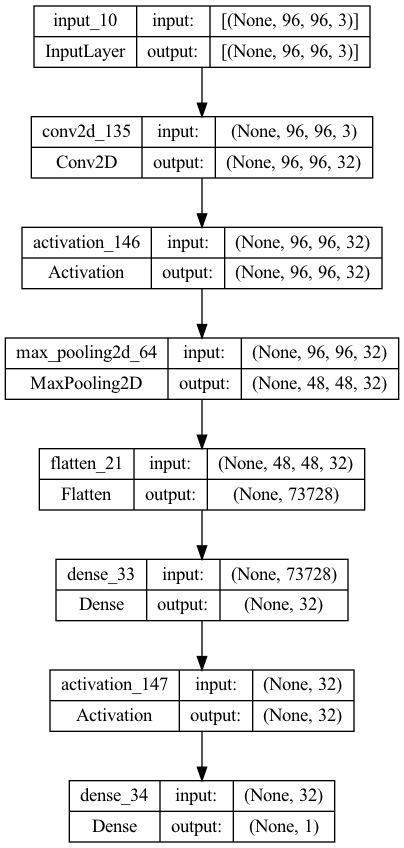

In [212]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [213]:
history = model.fit(train_generator,
                    validation_data=valid_generator,
                    epochs=10, verbose=1
)

Epoch 1/10


2022-10-10 15:48:49.180690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5157/5157 [==============================] - ETA: 0s - loss: 0.4666 - accuracy: 0.7858

2022-10-10 15:52:15.468257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5157/5157 [==============================] - 271s 52ms/step - loss: 0.4666 - accuracy: 0.7858 - val_loss: 0.4223 - val_accuracy: 0.8098
Epoch 2/10
5157/5157 [==============================] - 256s 50ms/step - loss: 0.4318 - accuracy: 0.8039 - val_loss: 0.4271 - val_accuracy: 0.8049
Epoch 3/10
5157/5157 [==============================] - 258s 50ms/step - loss: 0.4175 - accuracy: 0.8117 - val_loss: 0.4034 - val_accuracy: 0.8199
Epoch 4/10
5157/5157 [==============================] - 257s 50ms/step - loss: 0.4048 - accuracy: 0.8182 - val_loss: 0.3848 - val_accuracy: 0.8301
Epoch 5/10
5157/5157 [==============================] - 258s 50ms/step - loss: 0.3968 - accuracy: 0.8220 - val_loss: 0.3829 - val_accuracy: 0.8320
Epoch 6/10
5157/5157 [==============================] - 257s 50ms/step - loss: 0.3903 - accuracy: 0.8254 - val_loss: 0.3800 - val_accuracy: 0.8341
Epoch 7/10
5157/5157 [==============================] - 260s 50ms/step - loss: 0.3857 - accuracy: 0.8289 - val_loss: 0.3734 - val

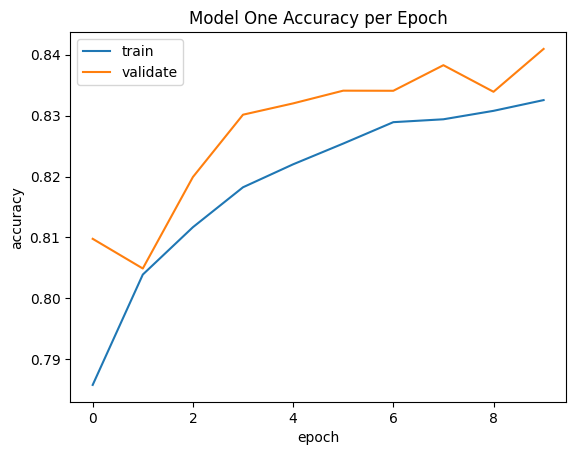

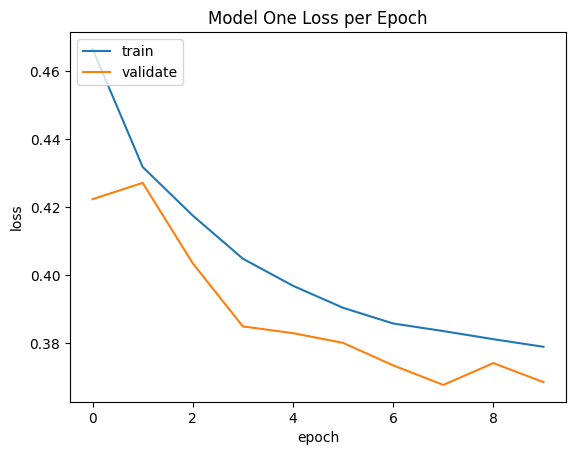

1719/1719 [==============================] - 65s 38ms/step


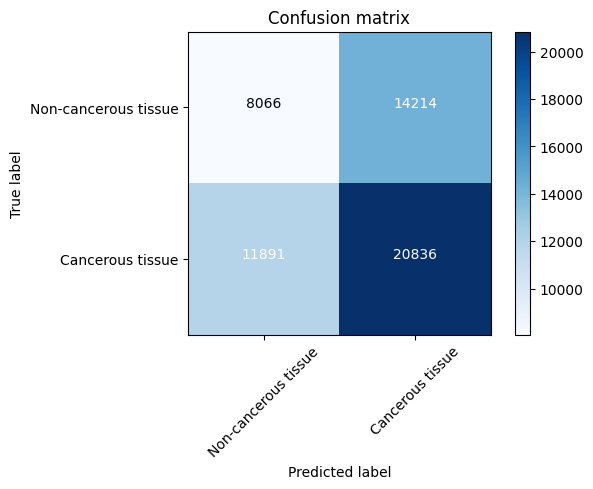

Total images with cancerous tissue detected in validation set: 20836 of 32727
Total images with no cancerous tissue detected in validation set: 8066 of 22280
Probability to detect a image with cancerous tissue  in the validation set: 0.64
Probability to detect a image with no cancerous tissue  tweet in the validation set: 0.36
Accuracy of unsupervised model on the validation set: 52.54%


In [228]:
evaluate_model(history, model, valid_generator, valid_generator.labels)

- Validation accuracy pleateous after approx. 7 epochs while training accuracy keeps going up
    1. The model's most likely over-fitting.
    2. The model has _learnt_ as many intricricacies from the training data as it could but hasn't been able to generalize it enough to perform better on the validation set.
- Potential fixes:
    - Add image augmentation layers such as `RandomFlip` and `RandomRotation` to help the model gain more information from our training data. These layers help create _new_ data from the existing dataset by flipping or rotating the images. Therefore, helping the model become more generalizable. 
    - Add `Dropout` layers
    - Reduce the learning rate
    - Reduce the # of layers 
    - Reduce the # of epochs
- Let's first try adding the image augmentation layers & dropout layers mentioned above. If the scores don't improve, we can implement the other fixes as well.

## Train a bigger, better model

In [334]:
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=10,
    horizontal_flip=True,
    vertical_flip=True
)

train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,directory=train_path,
                                                    x_col="id",y_col="label",batch_size=32,seed=42,shuffle=True,
                                                    class_mode="binary",target_size=(96,96))

valid_generator = train_datagen.flow_from_dataframe(dataframe=valid_df,directory=train_path,
                                                    x_col="id",y_col="label",batch_size=32,seed=42,shuffle=True,
                                                    class_mode="binary",target_size=(96,96))

Found 165018 validated image filenames belonging to 2 classes.
Found 55007 validated image filenames belonging to 2 classes.


- Due to a [bug](https://github.com/tensorflow/tensorflow/issues/56242) in Tensorflow 2.9 & above (I'm using 2.10), I can't use any of the image preprocessing layers directly in the model definition. Adding these layers caused my model training to slow down by 5-6x.
- Therefore, I've added these preprocessing steps into the `ImageDataGenerator` object directly. I've set the `seed` to the exact same value as the `ImageDataGenerator` for previous model's data to ensure the same samples go into the training & validation dataset.

In [335]:
model2 = Sequential()

model2.add(Input(shape=(96,96,3)))

model2.add(Conv2D(32, (3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))


model2.add(Conv2D(64, (3, 3), padding="same"))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(64, (3, 3), padding="same"))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(AveragePooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(128, (3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(128, (3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(128, (3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(AveragePooling2D(pool_size=(2, 2)))
          
model2.add(Flatten())
model2.add(Dropout(0.5))
model2.add(Dense(64))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(Dense(1, activation='sigmoid'))

opt = tf.keras.optimizers.Adam(1e-4)
metric_AUC = tf.keras.metrics.AUC()
model2.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', metric_AUC])

- Adding AUC as a metric to improve the analysis of this model
- ROC curves are a quality measures of binary classifiers. They evaluate all the operational points of a model. 
- The metric calculates 4 new measures : `true_positives`, `true_negatives`, `false_positives` and `false_negatives`. These measures can then be used to calculate F1-scores, precision and recall. These metrics allow us to further test the validity of the model.

In [336]:
model2.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_178 (Conv2D)         (None, 96, 96, 32)        896       
                                                                 
 activation_204 (Activation)  (None, 96, 96, 32)       0         
                                                                 
 batch_normalization_134 (Ba  (None, 96, 96, 32)       128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_67 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_179 (Conv2D)         (None, 48, 48, 64)        18496     
                                                                 
 activation_205 (Activation)  (None, 48, 48, 64)     

**Flowchart of the bigger model**

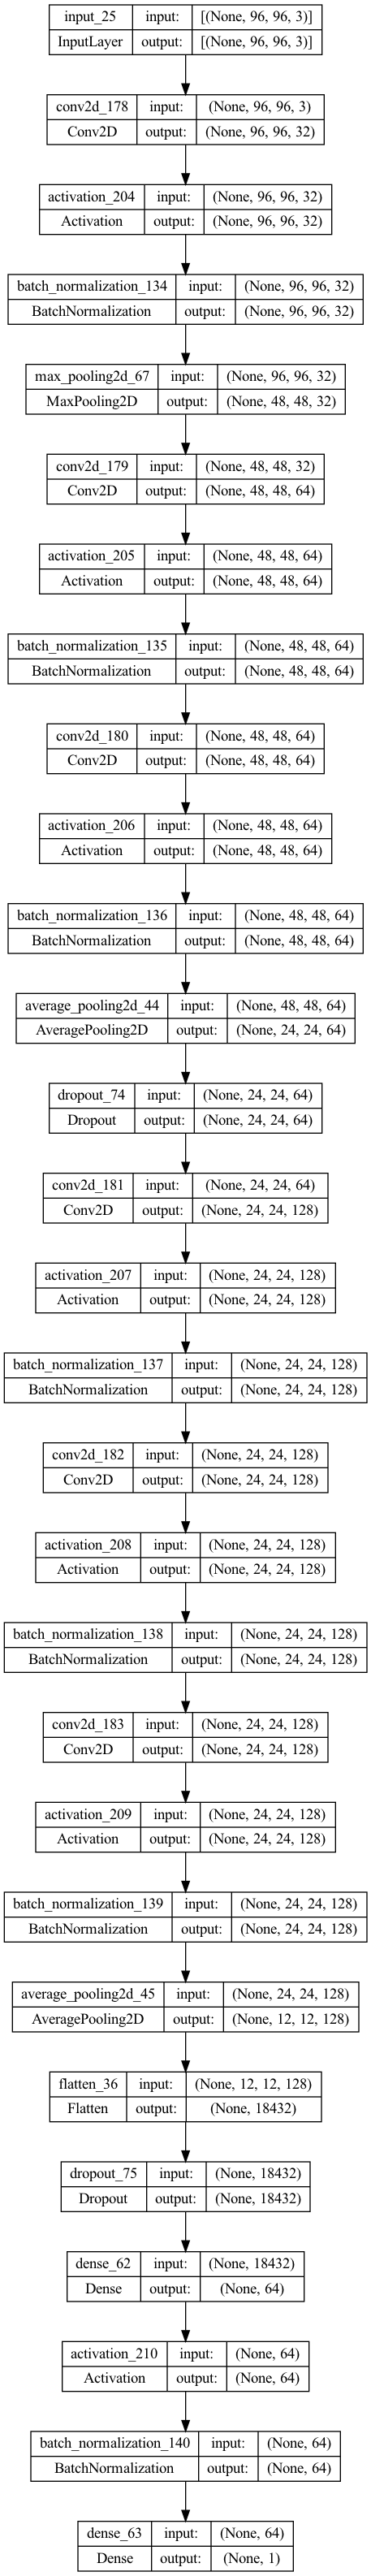

In [337]:
tf.keras.utils.plot_model(model2, show_shapes=True)

In [237]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=2)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
model_dir = './best_model/model2_best.h5'
checkpoint = ModelCheckpoint(model_dir, monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')
                              
                              
callbacks_list = [early_stop, reduce_lr, checkpoint]

- I have added a `checkpoint` callback to the list to save the best model since the model generated at the last epoch isn't necessarily the best one.
- The evidence of this can be found in the accuracy plot for previous model, the last model had a significantly fewer accuracy than the one at epoch #3.

In [238]:
history2 = model2.fit(train_generator,
                    validation_data=valid_generator,
                    epochs=10, verbose=1, callbacks=callbacks_list
)

Epoch 1/10


2022-10-10 16:55:07.903755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5156/5157 [============================>.] - ETA: 0s - loss: 0.3683 - accuracy: 0.8413 - auc_7: 0.9116

2022-10-10 16:58:45.324350: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.88102, saving model to ./best_model/model2_best.h5
5157/5157 [==============================] - 282s 54ms/step - loss: 0.3683 - accuracy: 0.8413 - auc_7: 0.9116 - val_loss: 0.2817 - val_accuracy: 0.8810 - val_auc_7: 0.9502 - lr: 1.0000e-04
Epoch 2/10
5157/5157 [==============================] - ETA: 0s - loss: 0.2734 - accuracy: 0.8886 - auc_7: 0.9515
Epoch 2: val_accuracy improved from 0.88102 to 0.89054, saving model to ./best_model/model2_best.h5
5157/5157 [==============================] - 284s 55ms/step - loss: 0.2734 - accuracy: 0.8886 - auc_7: 0.9515 - val_loss: 0.2750 - val_accuracy: 0.8905 - val_auc_7: 0.9516 - lr: 1.0000e-04
Epoch 3/10
5156/5157 [============================>.] - ETA: 0s - loss: 0.2358 - accuracy: 0.9065 - auc_7: 0.9635
Epoch 3: val_accuracy improved from 0.89054 to 0.92619, saving model to ./best_model/model2_best.h5
5157/5157 [==============================] - 281s 54ms/step - loss: 0.2358 - accuracy: 0.9066 - 

**Load the best model**

In [242]:
from tensorflow.keras.models import load_model
model2_best = load_model('./best_model/model2_best.h5')

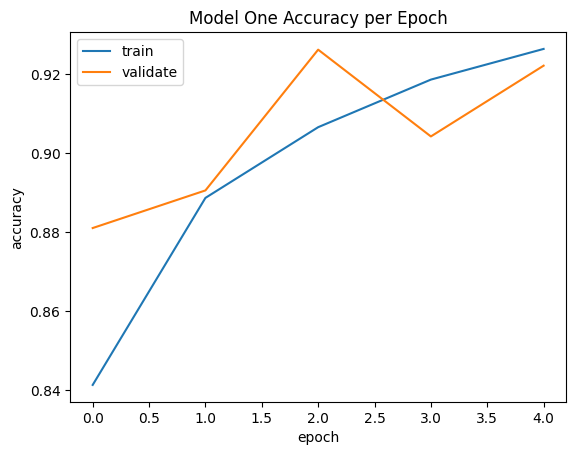

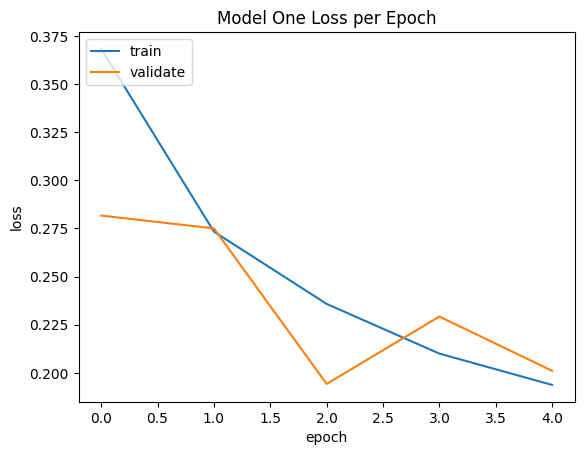

   1/1719 [..............................] - ETA: 6:12

2022-10-10 17:24:43.168164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1719/1719 [==============================] - 65s 38ms/step


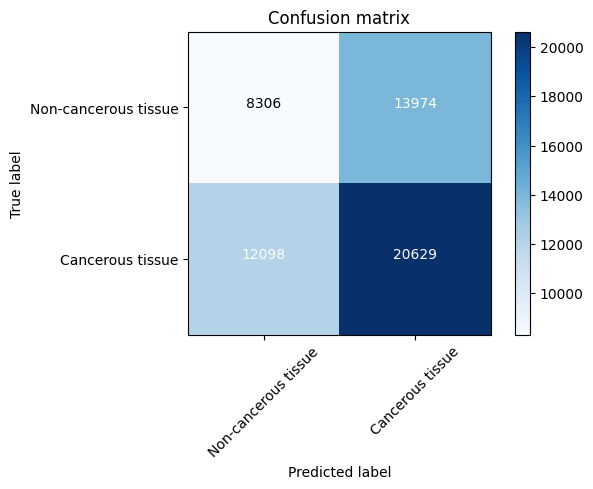

Total images with cancerous tissue detected in validation set: 20629 of 32727
Total images with no cancerous tissue detected in validation set: 8306 of 22280
Probability to detect a image with cancerous tissue  in the validation set: 0.63
Probability to detect a image with no cancerous tissue  tweet in the validation set: 0.37
Accuracy of unsupervised model on the validation set: 52.60%


In [243]:
evaluate_model(history2, model2_best, valid_generator, valid_generator.labels)

- The _bigger and better_ model only improved marginally over the baseline model :(
- Ability to detect an image with cancerous tissue actually went down by 0.1%
- However, the overall accuracy went up by 0.1%

## Hyperparameter Tuning

In [245]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [248]:
def build_model(num_conv_layers=1, dropout_level=0.5, learning_rate=1e-3):
    
    nn = Sequential()
    nn.add(Input(shape=(96,96,3)))
    
    
    for i in range(num_conv_layers):
        nn.add(Conv2D(64, (3, 3), padding="same"))
        nn.add(Activation('relu'))
        nn.add(BatchNormalization())
        nn.add(AveragePooling2D(pool_size=(2, 2)))
        nn.add(Dropout(dropout_level))
    
    nn.add(Flatten())
    nn.add(Dense(64))
    nn.add(Activation('relu'))
    nn.add(BatchNormalization())
    nn.add(Dense(1, activation='sigmoid'))
    
    opt = tf.keras.optimizers.Adam(learning_rate)
    nn.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
    
    return nn

In [341]:
parameters = {
    'epochs': [5, 10],
    'num_conv_layers': [1, 2, 4, 6]
}

In [342]:
total_combs = len(parameters['epochs']) * len(parameters['num_conv_layers'])

- Writing a custom grid search utility here since `GridSearchCV` doesn't work with `ImageGenerator` datasets.
- I searched around for a solution to this problem but to no avail.

In [344]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=2)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
model_dir = './best_model/model_gridsearch_best.h5'
checkpoint = ModelCheckpoint(model_dir, monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')

callbacks_list = [early_stop, reduce_lr, checkpoint]

i=0
print(f'Evaluating a total of {total_combs} combinations\n')

for epoch in parameters['epochs']:
    for num_layers in parameters['num_conv_layers']:
        
        print(f'Evaluating combination {i+1} of {total_combs} with epoch = {epoch} and number of conv layers = {num_layers}')
        model = build_model(num_layers)
        history = model.fit(train_generator,
                    validation_data=valid_generator,
                    epochs=epoch, verbose=0, callbacks=callbacks_list)
        i+=1
        print('===========================================================================')

Evaluating a total of 8 combinations

Evaluating combination 1 of 8 with epoch = 5 and number of conv layers = 1


2022-10-10 22:27:24.195762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-10 22:34:56.160832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.80484, saving model to ./best_model/model_gridsearch_best.h5

Epoch 2: val_accuracy did not improve from 0.80484

Epoch 3: val_accuracy improved from 0.80484 to 0.81782, saving model to ./best_model/model_gridsearch_best.h5

Epoch 4: val_accuracy did not improve from 0.81782

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 5: val_accuracy did not improve from 0.81782
Evaluating combination 2 of 8 with epoch = 5 and number of conv layers = 2


2022-10-10 23:13:02.206425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-10 23:16:52.045121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from 0.81782 to 0.83046, saving model to ./best_model/model_gridsearch_best.h5

Epoch 2: val_accuracy did not improve from 0.83046

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 3: val_accuracy did not improve from 0.83046
Evaluating combination 3 of 8 with epoch = 5 and number of conv layers = 4


2022-10-10 23:27:44.390132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-10 23:31:31.759467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from 0.83046 to 0.86487, saving model to ./best_model/model_gridsearch_best.h5

Epoch 2: val_accuracy did not improve from 0.86487

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 3: val_accuracy did not improve from 0.86487
Evaluating combination 4 of 8 with epoch = 5 and number of conv layers = 6


2022-10-10 23:42:09.529042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-10 23:46:05.119681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy did not improve from 0.86487

Epoch 2: val_accuracy did not improve from 0.86487

Epoch 3: val_accuracy did not improve from 0.86487

Epoch 4: val_accuracy did not improve from 0.86487

Epoch 5: val_accuracy did not improve from 0.86487
Evaluating combination 5 of 8 with epoch = 10 and number of conv layers = 1


2022-10-11 00:06:58.216810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-11 00:14:26.084801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy did not improve from 0.86487

Epoch 2: val_accuracy did not improve from 0.86487

Epoch 3: val_accuracy did not improve from 0.86487

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 4: val_accuracy did not improve from 0.86487
Evaluating combination 6 of 8 with epoch = 10 and number of conv layers = 2


2022-10-11 00:43:23.280417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-11 00:47:13.359055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy did not improve from 0.86487

Epoch 2: val_accuracy did not improve from 0.86487

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 3: val_accuracy did not improve from 0.86487
Evaluating combination 7 of 8 with epoch = 10 and number of conv layers = 4


2022-10-11 00:57:58.701650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-11 01:01:46.517880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy did not improve from 0.86487

Epoch 2: val_accuracy improved from 0.86487 to 0.87727, saving model to ./best_model/model_gridsearch_best.h5

Epoch 3: val_accuracy did not improve from 0.87727

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 4: val_accuracy did not improve from 0.87727
Evaluating combination 8 of 8 with epoch = 10 and number of conv layers = 6


2022-10-11 01:17:11.892039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-11 01:21:07.118687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy did not improve from 0.87727

Epoch 2: val_accuracy did not improve from 0.87727

Epoch 3: val_accuracy did not improve from 0.87727

Epoch 4: val_accuracy did not improve from 0.87727

Epoch 5: val_accuracy did not improve from 0.87727

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 6: val_accuracy did not improve from 0.87727


# Results

2022-10-11 07:11:10.494368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1719/1719 [==============================] - 66s 38ms/step


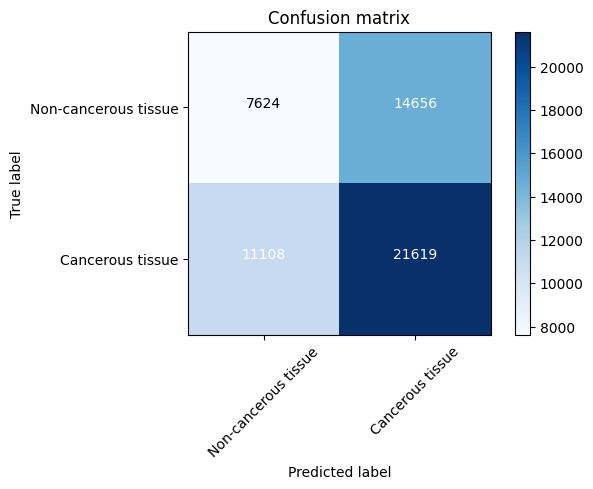

Total images with cancerous tissue detected in validation set: 21619 of 32727
Total images with no cancerous tissue detected in validation set: 7624 of 22280
Probability to detect a image with cancerous tissue  in the validation set: 0.66
Probability to detect a image with no cancerous tissue  tweet in the validation set: 0.34
Accuracy of unsupervised model on the validation set: 53.16%


In [345]:
model_grid_best = load_model('./best_model/model_gridsearch_best.h5')
evaluate_model(None, model_grid_best, valid_generator, valid_generator.labels)

- Hyperparameter tuning improved scores in certain areas while maintained the status quo in others when compared the second model.
- Drops
    - Probability of detecting a non-cancerous image went down by 1%
- Improvements
    - Overall accuracy went up by 1%
    - Probability of detecting a cancerous image went up by 2%
- Potential reasons behind the lackluster performance of a _hypertuned_ model
    - The parameter grid is too small
    - Need more data to push into the model

# Conclusion

- Early detection of cancer is a crucial problem to solve in the medical field. ML models can be a huge asset in solving this problem because they can churn through a vast amount of records faster than humans and flag cases down for doctors to analyse. 
- My options of choosing which hyperparameters to tune were limited by GPU & time constraints. 
    - Each epoch takes approximately 5 minutes to train.
    - The total # of epochs for the current parameter grid sits at 45 epochs. The current hyperparameter tuning took almost 45 epochs * 5 mins/epoch = 225 mins ~ 3.75 hours
- However, if I were to expand the parameters list, I would add the following
    - `learning_rate` for the optimizer
    - bigger range for number of `convolution` layers
    - bigger range for number of `epochs`
- Despite the long training time, the results proved _not worth_ it. As mentioned above, there could be a multitude of reasons behind this. Some are easy to fix, i.e. expand the parameter grid whereas others are harder to accomplish, i.e. gather more data.
- For next steps, I would like to 
    - Assemble a bigger training rig (with more GPUs, faster CPU and more RAM) to input significantly more data into the model. This will massively improve the generalization of the model.
    - Try huge pre-trained models such as Microsoft's ResNet or Google's VIT and train them to detect cancerous tissue in pathology scans.

# Submission

In [182]:
sample_submission = pd.read_csv('./histopathologic-cancer-detection/sample_submission.csv')
sample_submission['id'] = sample_submission['id'] + '.tif'
sample_submission.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5.tif,0
1,95596b92e5066c5c52466c90b69ff089b39f2737.tif,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914.tif,0
3,2c35657e312966e9294eac6841726ff3a748febf.tif,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6.tif,0


In [183]:
test_datagen = ImageDataGenerator(
    rescale=1/255
)

In [184]:
test_generator=test_datagen.flow_from_dataframe(dataframe=sample_submission,directory=test_path,
                                                  x_col="id",y_col=None,
                                                  batch_size=1,
                                                  class_mode=None,
                                                  target_size=(96,96))

Found 57458 validated image filenames.


In [189]:
preds = model2.predict(test_generator)

   15/57458 [..............................] - ETA: 3:29   

2022-10-08 16:49:24.975551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


57458/57458 [==============================] - 126s 2ms/step


In [190]:
preds[:10]

array([[0.00769429],
       [0.5587362 ],
       [0.9956728 ],
       [0.19187868],
       [0.00736793],
       [0.1330614 ],
       [0.07220374],
       [0.12752138],
       [0.92961824],
       [0.99698836]], dtype=float32)

In [191]:
np.unique(np.round(preds), return_counts=True)

(array([0., 1.], dtype=float32), array([42159, 15299]))

In [192]:
sample_submission['id'] = sample_submission['id'].apply(lambda x: x.split('.')[0])
sample_submission['label'] = [0 if pred < 0.5 else 1 for pred in preds]

In [193]:
sample_submission.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,1
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,1
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [194]:
sample_submission.to_csv("submission.csv", index=False)

In [195]:
!kaggle competitions submit -c histopathologic-cancer-detection -f submission.csv -m "no hypertuning yet x2"

100%|███████████████████████████████████████| 2.36M/2.36M [00:03<00:00, 715kB/s]
Successfully submitted to Histopathologic Cancer Detection